### **Libararies and Data:** 

In [ ]:
# import libararies
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, confusion_matrix

from time import time
import warnings
warnings.filterwarnings('ignore')
pd.set_option("max_columns",0)

In [ ]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [60]:
df = pd.read_csv('/content/drive/MyDrive/Naya - Keren Ohad Rotem/CSV/df_final_eda.csv')
df=df.drop(columns=['Unnamed: 0'])

In [61]:
df

,TARGET,GENDER,OWN_CAR,OWN_REALTY,CNT_CHILDREN,AMT_INCOME,AMT_APP,DAYS_BIRTH,DAYS_EMPLOYED,PHONE_CHANGE,TYPE_HOUSE:House,REGION_RATING:A,REGION_RATING:B,REGION_RATING:C,TYPE_INCOME:Associate,TYPE_INCOME:Pensioner,TYPE_INCOME:Working,TYPE_EDUCATIOM:Higher,FAMILY_STATUS:Married,BU_NUM_LOAN,BU_SUM_LOAN,BU_SUM_OPEN_DEBT,BU_PER_ACCTIVE,HC_NUM_APP,HC_MEAN_AMT_APP,HC_MEAN_PER_AMT_APPROVAL,HC_PER_ACCTIVE,HC_PER_DEBT,HC_MEAN_NUM_INST,HC_MEAN_AMT_INST,HC_MEAN_DELAY_INST,HC_MEAN_AMT_DIFF_INST,HC_PER_UNPAID_INST
0,1,0,1,0,0,202500,406597,-9461,-637,-1134,1,0,1,0,0,0,1,0,0,8,865055,245781,0.25,1,179055,1.00,1.00,0.0,19,11559,-20,0,0.0
1,0,1,1,1,0,270000,1293502,-16765,-1188,-828,1,1,0,0,0,0,1,1,1,4,1017400,0,0.25,3,435436,1.06,0.33,0.0,8,64755,-7,0,0.0
2,0,0,0,0,0,67500,135000,-19046,-225,-815,1,0,1,0,0,0,1,0,0,2,189037,0,0.00,1,24282,0.83,0.00,0.0,3,7096,-8,0,0.0
3,0,0,1,0,0,121500,513000,-19932,-3038,-1106,1,0,1,0,0,0,1,0,0,1,146250,0,0.00,5,135636,1.00,0.40,0.0,13,12214,-4,-452,0.0
4,0,0,1,0,0,99000,490495,-16941,-1588,-2536,1,0,1,0,0,0,1,0,1,3,468445,240057,0.33,4,194627,0.98,0.00,0.0,8,27361,26,-342,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245504,0,1,1,0,0,112500,345510,-11870,-399,-2315,1,0,1,0,1,0,0,1,0,11,5185462,2193390,0.27,4,61663,0.98,0.25,0.0,5,12928,-7,0,0.0
245505,0,1,1,0,0,112500,225000,-24384,0,0,1,0,1,0,0,1,0,0,0,13,3693858,163071,0.15,1,180000,1.07,0.00,0.0,12,22771,-2,0,0.0
245506,0,1,1,0,0,153000,677664,-14966,-7921,-1909,1,0,0,1,0,0,1,1,0,4,3960000,1795833,0.50,2,24162,0.83,0.50,0.0,5,4482,-18,-361,0.0
245507,1,1,1,0,0,171000,370107,-11961,-4786,-322,1,0,1,0,1,0,0,0,1,1,45000,0,0.00,2,121317,1.12,1.00,0.0,9,10240,-19,0,0.0


In [62]:
df.columns

Index(['TARGET', 'GENDER', 'OWN_CAR', 'OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME', 'AMT_APP', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'PHONE_CHANGE',
       'TYPE_HOUSE:House', 'REGION_RATING:A', 'REGION_RATING:B',
       'REGION_RATING:C', 'TYPE_INCOME:Associate', 'TYPE_INCOME:Pensioner',
       'TYPE_INCOME:Working', 'TYPE_EDUCATIOM:Higher', 'FAMILY_STATUS:Married',
       'BU_NUM_LOAN', 'BU_SUM_LOAN', 'BU_SUM_OPEN_DEBT', 'BU_PER_ACCTIVE',
       'HC_NUM_APP', 'HC_MEAN_AMT_APP', 'HC_MEAN_PER_AMT_APPROVAL',
       'HC_PER_ACCTIVE', 'HC_PER_DEBT', 'HC_MEAN_NUM_INST', 'HC_MEAN_AMT_INST',
       'HC_MEAN_DELAY_INST', 'HC_MEAN_AMT_DIFF_INST', 'HC_PER_UNPAID_INST'],
      dtype='object')

In [63]:
def time_stamp_decoration(func):
    def add_time_stamp(*args, **kwargs):
        t_start = time()
        print(f'Executing {func.__name__}...', end=' ')
        ret = func(*args, **kwargs)
        print("completed! ({:.3f} seconds)".format(time() - t_start))
        return ret
    return add_time_stamp

### **Pipeline functions:** 

#### **Scaling**

In [ ]:
@time_stamp_decoration
def scaler(df_train, df_test, scaler, col, idx_train, idx_test):
  """
    Scaler

    input:
      scaler: a scaler object after call 
      (Ex: scaler:scaler_MM after run outside scaler_MM = MinMaxScaler())
      col: list of the columns dataframe
      idx_train/test: list of the indexes train/test dataframe
    
    output:
      sc_train: data_train scaled by fitted scaler
      sc_test: data_test scaled by fitted scaler
  """

  scaler.fit(df_train)
  sc_train = scaler.transform(df_train)
  sc_train = pd.DataFrame(sc_train, columns = col, index = idx_train)
  sc_test = scaler.transform(df_test)
  sc_test = pd.DataFrame(sc_test, columns = col, index = idx_test)
  
  return (sc_train, sc_test)

#### **Cross Validation**

In [ ]:
@time_stamp_decoration
def CV_model(x, y, k_fold, model, **model_params):
  """
    Cross Validation

    input:
      model: a model object after call
      (Ex: model:model_Log after run outside model_Log = LogisticRegression())
      model_params: a dictionary of model params

    output:
      model_proba: an array with dim(n_samples, n_classes) of probabilities
  """

  kf = StratifiedKFold(n_splits=k_fold, shuffle=True)
  scores = cross_val_score(model ,x, y, fit_params=model_params, cv=kf, scoring='roc_auc')
  proba = cross_val_predict(model ,x, y, fit_params=model_params, cv=kf, method='predict_proba')[:, 1]
  print("Scores : " + (k_fold * "{:.3f} ").format(*scores))
  # model.fit(x, y, fit_params=model_params)
  # proba = model.predict_proba(x)[:, 1]

  return (proba)


#### **Grid Search**

In [ ]:
@time_stamp_decoration
def GS_model(x, y, k_fold, model, **grid_params):
  """
    Grid Search
    
    input:
      model: a model object after call
      (Ex: model:model_Log after run outside model_Log = LogisticRegression())
      grid_params: a dictionary of model params

    output:
      model_proba: an array with dim(n_samples, n_classes) of probabilities
      gs_model: fitted model
  """

  kf= StratifiedKFold(n_splits=k_fold, shuffle=True)
  gs_model = GridSearchCV(model, param_grid=grid_params, return_train_score=True,
                          cv=kf, scoring='roc_auc')
  gs_model.fit(x, y)
  print("Best parameters:", gs_model.best_params_)
  print("Train_scores:", gs_model.cv_results_['mean_train_score'])
  print("Test_scores:", gs_model.cv_results_['mean_test_score'])
  print("Best_score:", gs_model.best_score_)
  proba = gs_model.predict_proba(x)[:, 1]

  return (gs_model, proba)

#### **Report**

In [ ]:
@time_stamp_decoration
def report(x, y, proba, fitted_model):
  """
  report model
  """
  yp = fitted_model.predict(x)
  auc = roc_auc_score(y_true=y, y_score=proba)
  cm = pd.DataFrame(confusion_matrix(y_true=y, 
                                      y_pred=yp), 
                    index=fitted_model.classes_, 
                    columns=fitted_model.classes_)
  rep = classification_report(y_true=y, 
                              y_pred=yp)
  return 'roc_auc_score: {:.3f}\n\n{}\n\n{}'.format(auc, cm, rep)

#### **Feature Importance**

In [ ]:
@time_stamp_decoration
def featureImp(x, model, fitted_model):
  """
  plot the most 15 important features of the model
  """
  sort = fitted_model.best_estimator_.feature_importances_.argsort()[:15]
  plt.barh(x.columns[sort], fitted_model.best_estimator_.feature_importances_[sort])
  plt.title('Feature Importance '+model.__class__.__name__, fontsize = 20)
  return()

#### **ROC Curve**

In [ ]:
@time_stamp_decoration
def ROC_curves(y, **models_proba):
  """
  plot multiple ROC curves for multiple models
  """

  plt.style.use('seaborn')
  colors = {0:'green', 1:'red', 2:'orange', 3:'purple', 4:'brown', 5:'pink', 6:'cyan'}
  
  random_proba = [0 for i in range(len(y))]
  p_fpr, p_tpr, _ = roc_curve(y_true=y, y_score=random_proba, pos_label=1)
  plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')

  for i, (k, v) in enumerate(models_proba.items()):
    fpr, tpr, _ = roc_curve(y_true=y, y_score=v, pos_label=1)
    plt.plot(fpr, tpr, linestyle='--',color=colors[i], label=k)

  # title
  plt.title('ROC curve', fontsize = 20)
  # x label
  plt.xlabel('False Positive Rate', fontsize = 16)
  # y label
  plt.ylabel('True Positive rate', fontsize = 16)

  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.legend(loc='best', fontsize = 14)
  plt.show();

  return()
# https://www.analyticsvidhya.com/blog/2020/06/auc-roc-curve-machine-learning/  - ploting many AUC to see them agains wech other    

### **Train models:**

#### **Preprocessing**

In [64]:
# Split the data to train and test sets:
X=df.drop('TARGET', axis=1)
y=df.TARGET
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, test_size=0.25, 
                                                    random_state=123456, shuffle=True, stratify=y)

# Scaling:
scaler_MM = MinMaxScaler()
sc_train, sc_test = scaler(X_train, X_test, scaler_MM, X_train.columns, X_train.index, X_test.index)

# Set k_fold parameter:
k = 5

Executing scaler... completed! (0.148 seconds)


#### **Logistic Regression**

In [65]:
model_Log = LogisticRegression()
grid_param_Log = {'penalty': ['l2'],
                  'C': [1.0],
                  'class_weight': ['balanced'],
                  'solver': ['saga']
                  }

fitted_model_Log, proba_Log = GS_model(sc_train, y_train, k, model_Log, **grid_param_Log)
print(report(sc_train, y_train, proba_Log, fitted_model_Log))

Executing GS_model... Best parameters: {'C': 1.0, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'saga'}
Train_scores: [0.68500004]
Test_scores: [0.68378937]
Best_score: 0.6837893714674752
completed! (61.161 seconds)
Executing report... completed! (0.582 seconds)
roc_auc_score: 0.685

        0      1
0  106532  63243
1    5085   9271

              precision    recall  f1-score   support

           0       0.95      0.63      0.76    169775
           1       0.13      0.65      0.21     14356

    accuracy                           0.63    184131
   macro avg       0.54      0.64      0.49    184131
weighted avg       0.89      0.63      0.71    184131



#### **Random Forest**

Executing GS_model... Best parameters: {'class_weight': 'balanced', 'max_depth': 10, 'min_weight_fraction_leaf': 0.01, 'n_estimators': 50}
Train_scores: [0.7087919]
Test_scores: [0.69083146]
Best_score: 0.6908314646287753
completed! (78.925 seconds)
Executing report... completed! (1.588 seconds)
roc_auc_score: 0.705

        0      1
0  112225  57550
1    5124   9232

              precision    recall  f1-score   support

           0       0.96      0.66      0.78    169775
           1       0.14      0.64      0.23     14356

    accuracy                           0.66    184131
   macro avg       0.55      0.65      0.50    184131
weighted avg       0.89      0.66      0.74    184131

Executing featureImp... completed! (0.042 seconds)


()

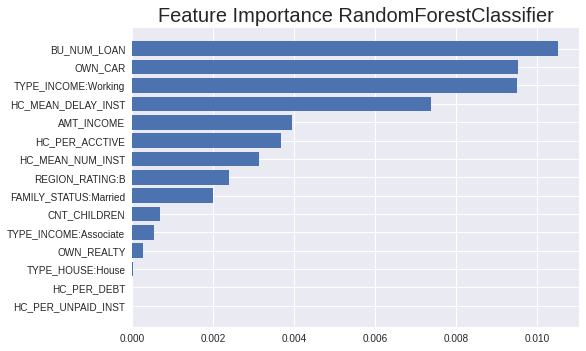

In [66]:
model_RF = RandomForestClassifier()
grid_param_RF = {'n_estimators': [50],
                 'max_depth': [10],
                 'class_weight': ['balanced'], 
                 'min_weight_fraction_leaf': [0.01]
                 }
fitted_model_RF, proba_RF = GS_model(sc_train, y_train, k, model_RF, **grid_param_RF)
print(report(sc_train, y_train, proba_RF, fitted_model_RF))
featureImp(sc_train, model_RF, fitted_model_RF)

#### **XGBoost**

Executing GS_model... Best parameters: {'alpha': 10, 'class_weight': {1: 20}, 'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 5}
Train_scores: [0.75702621]
Test_scores: [0.71036215]
Best_score: 0.7103621469666741
completed! (107.183 seconds)
Executing report... completed! (1.710 seconds)
roc_auc_score: 0.749

        0   1
0  169774   1
1   14341  15

              precision    recall  f1-score   support

           0       0.92      1.00      0.96    169775
           1       0.94      0.00      0.00     14356

    accuracy                           0.92    184131
   macro avg       0.93      0.50      0.48    184131
weighted avg       0.92      0.92      0.88    184131

Executing featureImp... completed! (0.199 seconds)


()

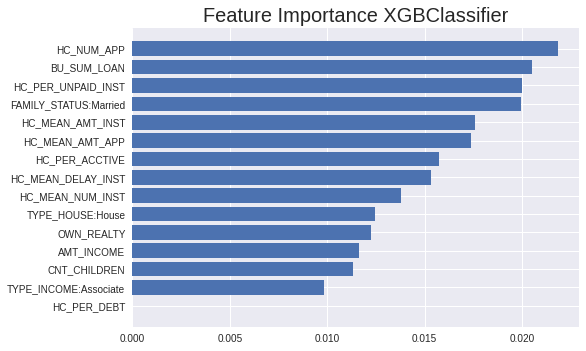

In [67]:
model_XGB = xgb.XGBClassifier()
grid_param_XGB = {'colsample_bytree': [0.3],
                  'learning_rate': [0.1],
                  'max_depth': [5],
                  'class_weight': [{1:20}], 
                  'alpha': [10]
                  }
fitted_model_XGB, proba_XGB = GS_model(sc_train, y_train, k, model_XGB, **grid_param_XGB)
print(report(sc_train, y_train, proba_XGB, fitted_model_XGB))
featureImp(sc_train, model_XGB ,fitted_model_XGB)

#### **LightGBM**

Executing GS_model... Best parameters: {'bagging_fraction': 1, 'bagging_freq': 1, 'boosting': 'gbdt', 'class_weight': {1: 20}, 'feature_fraction': 0.5, 'learning_rate': 0.05, 'metric': 'auc', 'num_leaves': 60, 'objective': 'binary', 'verbose': -5}
Train_scores: [0.78919897]
Test_scores: [0.70803179]
Best_score: 0.7080317921067382
completed! (41.319 seconds)
Executing report... completed! (2.553 seconds)
roc_auc_score: 0.776

       0      1
0  72095  97680
1   1252  13104

              precision    recall  f1-score   support

           0       0.98      0.42      0.59    169775
           1       0.12      0.91      0.21     14356

    accuracy                           0.46    184131
   macro avg       0.55      0.67      0.40    184131
weighted avg       0.92      0.46      0.56    184131

Executing featureImp... completed! (0.025 seconds)


()

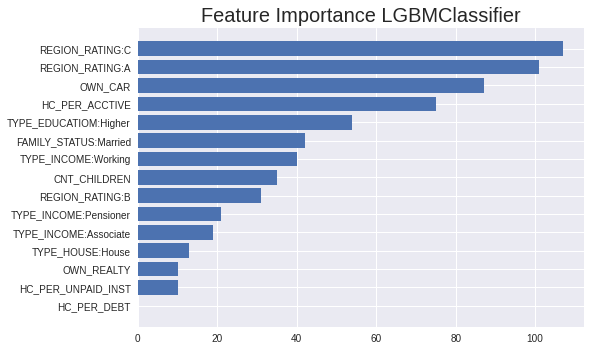

In [68]:
model_LGBM = lgb.LGBMClassifier()
grid_param_LGBM = {'objective': ['binary'],
                   'class_weight': [{1:20}],
                   'boosting': ['gbdt'],
                   'metric': ['auc'],
                   'num_leaves': [60],
                   'learning_rate': [0.05],
                   'feature_fraction': [0.5],
                   'bagging_fraction': [1],
                   'bagging_freq': [1],
                   'verbose': [-5]
                   }
fitted_model_LGBM, proba_LGBM = GS_model(sc_train, y_train, k, model_LGBM, **grid_param_LGBM)
print(report(sc_train, y_train, proba_LGBM, fitted_model_LGBM))
featureImp(sc_train, model_LGBM ,fitted_model_LGBM)

### **ROC Curves Figure of all the models:**

#### **Train**

Executing ROC_curves... 

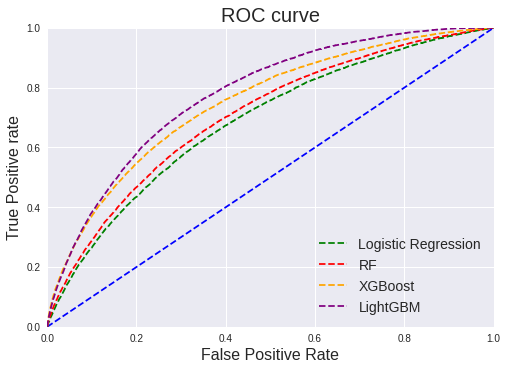

completed! (0.620 seconds)


()

In [69]:
dic_models = {'Logistic Regression': proba_Log,
              'RF': proba_RF,
              'XGBoost': proba_XGB,
              'LightGBM': proba_LGBM
              }
ROC_curves(y_train, **dic_models)

#### **Test**

In [70]:
proba_test_Log = fitted_model_Log.predict_proba(sc_test)[:, 1]
proba_test_RF = fitted_model_RF.predict_proba(sc_test)[:, 1]
proba_test_XGB = fitted_model_XGB.predict_proba(sc_test)[:, 1]
proba_test_LGBM = fitted_model_LGBM.predict_proba(sc_test)[:, 1]

In [71]:
# Logistic Regression
print(report(sc_test, y_test, proba_test_Log, fitted_model_Log))

Executing report... completed! (0.299 seconds)
roc_auc_score: 0.677

       0      1
0  35504  21088
1   1756   3030

              precision    recall  f1-score   support

           0       0.95      0.63      0.76     56592
           1       0.13      0.63      0.21      4786

    accuracy                           0.63     61378
   macro avg       0.54      0.63      0.48     61378
weighted avg       0.89      0.63      0.71     61378



In [72]:
# Random Forest
print(report(sc_test, y_test, proba_test_RF, fitted_model_RF))

Executing report... completed! (1.362 seconds)
roc_auc_score: 0.688

       0      1
0  37284  19308
1   1847   2939

              precision    recall  f1-score   support

           0       0.95      0.66      0.78     56592
           1       0.13      0.61      0.22      4786

    accuracy                           0.66     61378
   macro avg       0.54      0.64      0.50     61378
weighted avg       0.89      0.66      0.74     61378



In [73]:
# XGBoost
print(report(sc_test, y_test, proba_test_XGB, fitted_model_XGB))

Executing report... completed! (0.547 seconds)
roc_auc_score: 0.708

       0  1
0  56589  3
1   4784  2

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56592
           1       0.40      0.00      0.00      4786

    accuracy                           0.92     61378
   macro avg       0.66      0.50      0.48     61378
weighted avg       0.88      0.92      0.88     61378



In [74]:
# LightGBM
print(report(sc_test, y_test, proba_test_LGBM, fitted_model_LGBM))

Executing report... completed! (0.887 seconds)
roc_auc_score: 0.708

       0      1
0  23398  33194
1    763   4023

              precision    recall  f1-score   support

           0       0.97      0.41      0.58     56592
           1       0.11      0.84      0.19      4786

    accuracy                           0.45     61378
   macro avg       0.54      0.63      0.39     61378
weighted avg       0.90      0.45      0.55     61378



Executing ROC_curves... 

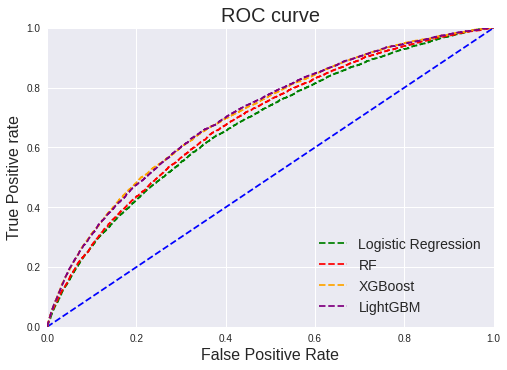

completed! (0.331 seconds)


()

In [75]:
dic_test_models = {'Logistic Regression': proba_test_Log,
                   'RF': proba_test_RF,
                   'XGBoost': proba_test_XGB,
                   'LightGBM': proba_test_LGBM
                   }
ROC_curves(y_test, **dic_test_models)